### A/334 Parameter Specification
- Autocorrection Delay = 3ms
- Sysmbol interval T = 1/106 seconds
- Marking Frequency Band = 2.5kHz - 5.0kHz

### Sample 
- frequency 48kHz -> 48000 frames/second
- Symbol frames 48000/106 = ca. 453 frames

### Help


In [1]:
import wave
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import acf
from scipy.signal import butter, lfilter

In [2]:
with wave.open('audio.wav', 'rb') as w:
    samplerate = w.getframerate()
    frames = w.getnframes()
    channels = w.getnchannels()
    width = w.getsampwidth()
    print('sampling rate:', samplerate, 'Hz')
    print('length:', frames, 'samples')
    print('channels:', channels)
    print('sample width:', width, 'bytes')
    
    data = w.readframes(frames)


sampling rate: 48000 Hz
length: 14880384 samples
channels: 2
sample width: 2 bytes
sampling rate: 48000 Hz
length: 14880384 samples
channels: 2
sample width: 2 bytes


In [3]:
print(2*2*14880384) #channels * sample width * sample length = 59521536 bytes buffersize
print(len(data))
type(data)

59521536
59521536
59521536
59521536


bytes

bytes

In [4]:
sig = np.frombuffer(data, dtype='<i2').reshape(-1, channels)
offset_sec = 0.003
offset_frames = int(samplerate * offset_sec)
symbols_per_sec = 106
samples_per_symbol = samplerate / symbols_per_sec
samples_per_symbol

452.8301886792453

452.8301886792453

In [5]:
#https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [6]:
sig_bandpassed = butter_bandpass_filter(sig[:, 0], 2500, 5000, samplerate)

C:\Users\Janbe\AppData\Local\pypoetry\Cache\virtualenvs\video-watermark-decoder-evsskYxq-py3.10\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\Janbe\AppData\Local\pypoetry\Cache\virtualenvs\video-watermark-decoder-evsskYxq-py3.10\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


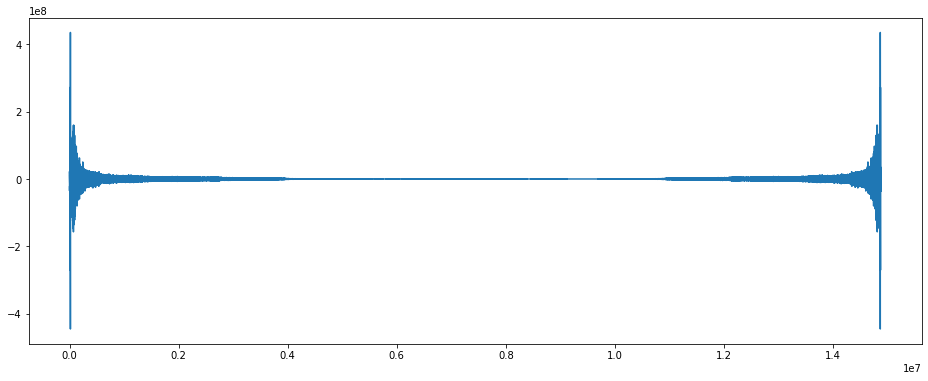

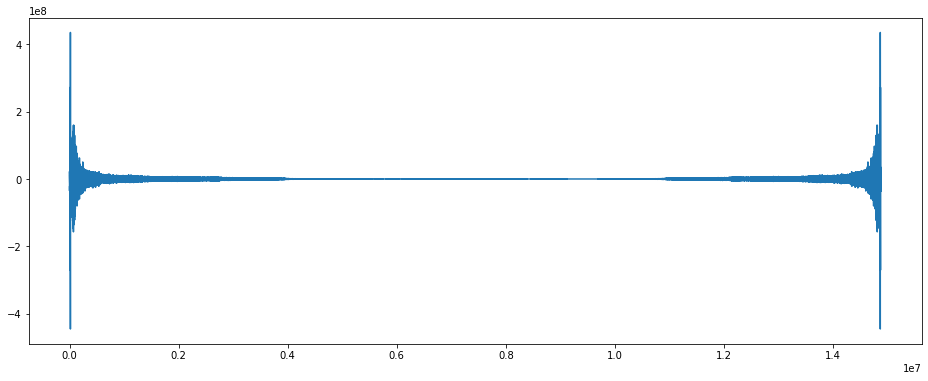

In [7]:
sig_fft = np.fft.fft(sig[:, 0])

plt.figure(figsize=(16, 6))
plt.plot(sig_fft)

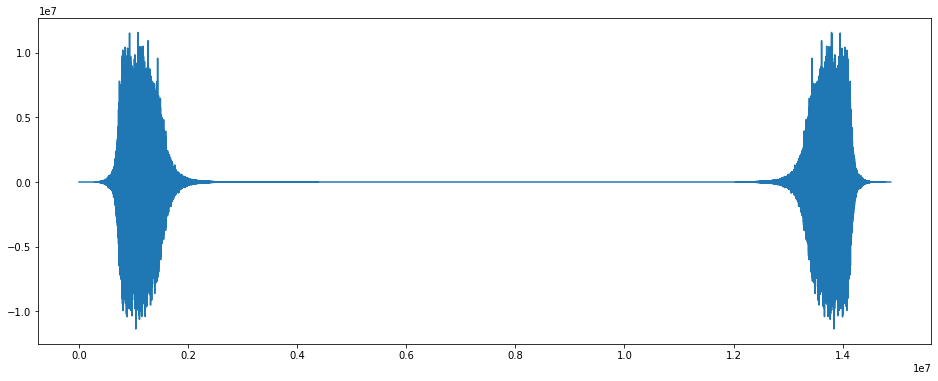

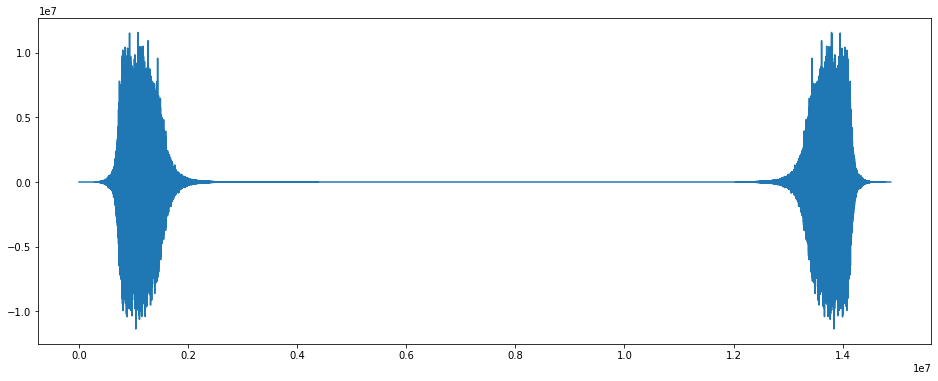

In [8]:
sig_fft = np.fft.fft(sig_bandpassed)

plt.figure(figsize=(16, 6))
plt.plot(sig_fft)

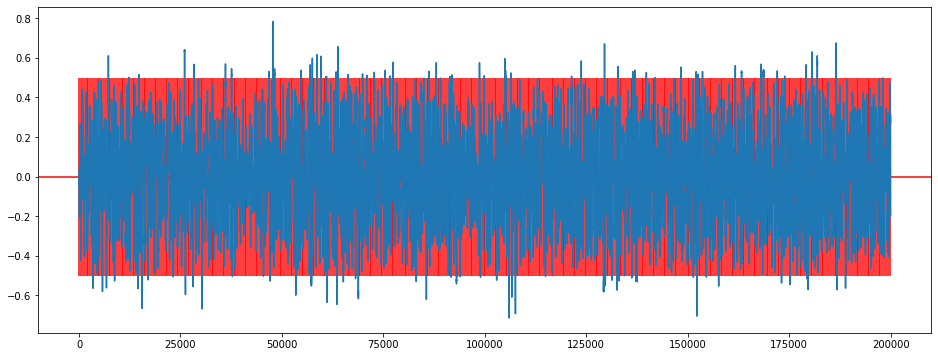

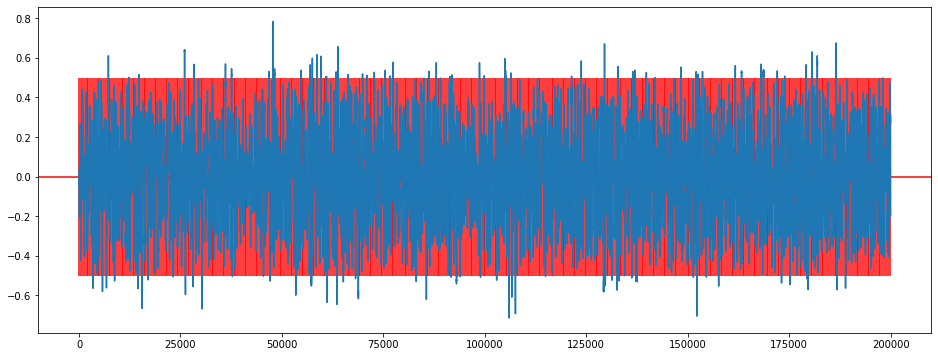

In [9]:
samples = 200000
sigg = sig_bandpassed
diffs = np.zeros(samples)
for i in range(samples):
    # TODO get rid of range and maybe average it
    orig_acf = acf(sigg[i:int(samples_per_symbol/2)+i], nlags=offset_frames)
    delay_acf = acf(sigg[i+int(samples_per_symbol/2):i+int(samples_per_symbol)], nlags=offset_frames)
    diffs[i] = orig_acf[-1] - delay_acf[-1]

plt.figure(figsize=(16, 6))
plt.vlines(np.arange(50,samples, samples_per_symbol), -0.5, 0.5, colors=["red"])
plt.axhline(y=0, color='r', linestyle='-')
plt.plot(diffs, '-')


In [10]:
MESSAGE_HEADER = '10101110000010101011100111100100'
for i in range(samples-3000):
    is_correct = True
    for j in range(len(MESSAGE_HEADER)):
        if not (diffs[int(j*samples_per_symbol+i)] >= 0 and MESSAGE_HEADER[j] == '1' or diffs[int(j*samples_per_symbol+i)] < 0 and MESSAGE_HEADER[j] == '0'):
            is_correct = False
            break
    if is_correct:
        print(f"found offset for message start {i}")

found offset for message start 71894
found offset for message start 71895
found offset for message start 71896
found offset for message start 71897
found offset for message start 71898
found offset for message start 71899
found offset for message start 71900
found offset for message start 71901
found offset for message start 71939
found offset for message start 71940
found offset for message start 71941
found offset for message start 71942
found offset for message start 71943
found offset for message start 71944
found offset for message start 71945
found offset for message start 71946
found offset for message start 71947
found offset for message start 71948
found offset for message start 71949
found offset for message start 71950
found offset for message start 71951
found offset for message start 71952
found offset for message start 71953
found offset for message start 71954
found offset for message start 71955
found offset for message start 71956
found offset for message start 71957
f

In [11]:
15000 / samples_per_symbol

33.125

33.125